In [4]:
import pandas as pd
import numpy as np
import scipy.stats
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pylab as pylab
import matplotlib.patches as mpatches
import time

params = {'legend.fontsize': 'x-small',
          'figure.figsize': (5, 3),
          'figure.dpi': 150,
          'axes.labelsize': 'small',
          'axes.titlesize': 'small',
          'xtick.labelsize': 'x-small',
          'ytick.labelsize': 'x-small'}
pylab.rcParams.update(params)

#path to the database
#source: https://www.kaggle.com/datasets/thoughtvector/podcastreviews
database = "database.sqlite"

# Helper functions

In [45]:
#helper function for visualizations
def plot_top_recommendations_vs_user(user_id, user_profile_ratings, rec_matrix, podcast_w_category, nr_cats=10, top_x=100, path=False):
    '''
    Plotting function used to visualize the top X recommendations and their overlap with the user's preferences
    '''
    #top categories to visualize
    nr_cats = nr_cats

    #top recommendations to examine
    top_x = top_x

    #downselecting the top x number of recommendations for comparison
    top_x_rec = rec_matrix.sort_values(ascending=False).head(top_x)

    #calculating the count of appearences for every category in the selection
    top_x_rec_cat = podcast_w_category.query(f'podcast_id in {list(top_x_rec.index)}').groupby('category').count()

    #plotting
    fig, ax = plt.subplots(ncols=1, nrows=1)

    df1 = top_x_rec_cat.sort_values('podcast_id', ascending=False).head(nr_cats)['podcast_title']
    df1.name = 'recommended'
    df2 = user_profile_ratings.sort_values(ascending=False).head(nr_cats)
    df2.name = 'user_profile'
    df3 = pd.merge(df1, df2, how='outer', left_index=True, right_index=True)

    ax = df3.sort_values('user_profile', ascending=False).plot(
        kind='bar', 
        ax=ax, 
        y=['user_profile', 'recommended'], 
        secondary_y='recommended',
        fontsize= 'xx-small',
        legend=True,
        mark_right=False
    )
    
    ax.set_ylabel('User Profile')
    ax.right_ax.set_ylabel(f'Counts')
    ax.set_title(f'{user_id}: Top {top_x} Recommendations vs. Profile')
    
    if path:
        plt.tight_layout()
        plt.savefig(f'{path}\\{user_id}.png')
        plt.close()
    else:
        plt.show()

# Data Loading

In [24]:
# get users with more than K reviews from db
K = 5

# get podcasts reviews from db
reviews = pd.read_sql(f"""
    SELECT podcast_id, title as review_title, content as review_content, rating, author_id, created_at
    FROM reviews
    WHERE author_id IN
    (
        SELECT author_id
        FROM reviews
        GROUP BY (author_id)
        HAVING COUNT(*) >= {K}
    )
""", sqlite3.connect(database))

# get podcasts with titles from db
podcasts = pd.read_sql("""
    select
        podcast_id,
        title
    from podcasts
""", sqlite3.connect(database))

# get podcasts with categories from db
podcast_w_category = pd.read_sql(f"""
    SELECT podcast_id, title as podcast_title, category
    FROM categories JOIN podcasts USING (podcast_id)
""", sqlite3.connect(database))

# Data Cleaning

In [25]:
# check if there are any duplicates
duplicates = reviews.duplicated(subset=['author_id','podcast_id'], keep='last')
total_duplicates = duplicates.shape[0] - (duplicates.shape[0] - duplicates.sum())

# remove based on boolean mask
reviews = reviews[~duplicates]
print(f'Removed {total_duplicates} duplicates ~ {round(duplicates.sum()/duplicates.shape[0],3)}% of total reviews')

Removed 43418 duplicates ~ 0.161% of total reviews


In [26]:
# get all podcast ids in podcast_w_category
pod_id_in_table = podcast_w_category['podcast_id'].unique()
# remove all author ids that are in reviews but not in podcast_w_category
before = reviews.shape[0]
reviews = reviews[reviews['podcast_id'].isin(pod_id_in_table)]
after = reviews.shape[0]
print(f'Removed {before - after} reviews ~ {round((before - after)/before,3)}% of total reviews')

Removed 3011 reviews ~ 0.013% of total reviews


# Hashing the podcast and user IDs

In [29]:
all_data = pd.merge(reviews, podcasts, on='podcast_id', how='inner')

#hashing the authors
unique_authors = all_data['author_id'].unique()
df_author_hash = pd.DataFrame(range(1,len(unique_authors)+1), index=unique_authors, columns=['hashcode'])

#hashing the podcasts
unique_podcasts = all_data['podcast_id'].unique()
df_podcast_hash = pd.DataFrame(range(1,len(unique_podcasts)+1), index=unique_podcasts, columns=['hashcode'])

all_data['author_hash'] = all_data['author_id'].apply(lambda x: df_author_hash.loc[x])
all_data['podcast_hash'] = all_data['podcast_id'].apply(lambda x: df_podcast_hash.loc[x])

# Data Clustering

In [5]:
reviews = pd.read_sql(f"""
    SELECT podcast_id, author_id, rating, reviews.created_at , reviews.title, reviews.content 
    FROM reviews
    Where rating > 3
""", sqlite3.connect(database))

podcast_w_category = pd.read_sql(f"""
    SELECT podcast_id, title as p_title, category
    FROM categories JOIN podcasts USING (podcast_id)
""", sqlite3.connect(database))

In [6]:
# for each podcast, concatenate all categories once you sort them
podcast_w_category = podcast_w_category.groupby("podcast_id").agg({"p_title": "first", "category": lambda x: "#".join(sorted(x))}).reset_index()

# sort by aurhor_id, podcast_id and created_at
reviews = reviews.sort_values(by=['author_id', 'podcast_id', 'created_at'])

In [7]:
# check if there are any duplicates
duplicates = reviews.duplicated(subset=['author_id','podcast_id'], keep='last')
total_duplicates = duplicates.shape[0] - (duplicates.shape[0] - duplicates.sum())

# remove based on boolean mask
reviews = reviews[~duplicates]
print(f'Removed {total_duplicates} duplicates ~ {round(duplicates.sum()/duplicates.shape[0],3)}% of total reviews')

Removed 59619 duplicates ~ 0.033% of total reviews


In [8]:
# get all podcast ids in podcast_w_category
pod_id_in_table = podcast_w_category['podcast_id'].unique()
# remove all author ids that are in reviews but not in podcast_w_category
before = reviews.shape[0]
reviews = reviews[reviews['podcast_id'].isin(pod_id_in_table)]
after = reviews.shape[0]
print(f'Removed {before - after} reviews ~ {round((before - after)/before,3)}% of total reviews')

Removed 21579 reviews ~ 0.012% of total reviews


In [9]:
# Keep only authors with at least K reviews
K = 5
reviews = reviews.groupby('author_id').filter(lambda x: len(x) >= K)

In [10]:
# print unique authors and reviews
print(f'Unique authors: {reviews["author_id"].unique().shape[0]}')
print(f'Unique reviews: {reviews.shape[0]}')

Unique authors: 18551
Unique reviews: 156646


In [11]:
# merge reviews with podcast_w_category
reviews_w_podcast_w_category = reviews.merge(podcast_w_category, on='podcast_id', how='inner')
# keep only the columns we need
reviews_w_podcast_w_category = reviews_w_podcast_w_category[['author_id', 'podcast_id', 'p_title', 'category', 'rating', 'created_at']]
reviews_w_podcast_w_category = reviews_w_podcast_w_category.sort_values(by=['author_id', 'created_at'], ascending=False)

In [12]:
# print unique authors
print(f'Unique authors: {reviews_w_podcast_w_category["author_id"].unique().shape[0]}')

Unique authors: 18551


In [13]:
def prepare_data_for_clustering(data, K):
    """
    data: dataframe with columns author_id, podcast_id, p_title, category, rating, created_at
    K: number of most recent reviews to consider
    """
    # get the K most recent reviews for each author
    data = data.copy()
    data = data.groupby('author_id').head(K)
    authors = data['author_id'].unique()
    total_authors = authors.shape[0]
    print(f'Unique authors: {total_authors} with >={K} reviews')

    # get the most frequent categories
    category_freq = reviews_w_podcast_w_category['category'].str.split('#').explode().value_counts().to_dict()

    # For each podcast category split the concatenated string into a list of categories and keep the 
    # most frequent category as the category of the podcast
    data = data[['author_id', 'category', 'created_at']]
    data['category'] = data['category'].str.split('#').apply(lambda x: max(x, key=lambda y: category_freq[y]))
    

    # represent each author as a vector of K categories
    matrix_K_categories = pd.DataFrame(index=authors, columns=['category_' + str(i) for i in range(K)])
    matrix_K_categories = matrix_K_categories.fillna("empty")
    # fill the matrix with the average rating of the author for the podcast title in order
    for index, author in enumerate (authors):
        index = index + 1
        categories = data[data['author_id'] == author]['category'].values
        for i in range(K):
            matrix_K_categories.loc[author, 'category_' + str(i)] = categories[i]
        if index % 3000 == 0:
            print(f'{index} authors processed')    


    return matrix_K_categories

In [14]:
def clustering(data, num_of_clusters, plot=False):
    # Categorical data clustering
    # Check source: https://www.analyticsvidhya.com/blog/2021/06/kmodes-clustering-algorithm-for-categorical-data/
    # Check source: https://medium.com/geekculture/the-k-modes-as-clustering-algorithm-for-categorical-data-type-bcde8f95efd7

    data = data.astype('str')

    from kmodes.kmodes import KModes
    import matplotlib.pyplot as plt
    import numpy as np

    centroids = None

    import time

    start_time = time.time()
    # create a KMeans instance with k clusters
    kmodes = KModes(n_clusters=num_of_clusters, init = 'random', verbose=0 , max_iter=100, n_jobs=1, random_state=42)
    # fit the model to the matrix
    kmodes.fit(data)
    end_time = time.time()
    # info about the clustering
    print(f"For K: {num_of_clusters} and init method random-> Max iterations: {kmodes.n_iter_}  Cost: {kmodes.cost_} Time: {round((end_time - start_time)/60,3)} minutes")
    # get centroids
    centroids = kmodes.cluster_centroids_
    #print(f"Centroids: {centroids}")
    # get labels
    data['cluster'] = kmodes.labels_

    data = data.reset_index()
    data = data.rename(columns={'index': 'author_id'})
    data = data[['author_id', 'cluster']]
    cost = kmodes.cost_
    return data, centroids, cost


In [15]:
cluster_Ks = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
matrix_K_categories = prepare_data_for_clustering(reviews_w_podcast_w_category, K)
cost_per_K = []
for K in cluster_Ks:
    print(f'Clustering for K={K}')
    data, centroids, cost = clustering(matrix_K_categories, K)
    cost_per_K.append(cost)

Unique authors: 18551 with >=5 reviews
3000 authors processed
6000 authors processed
9000 authors processed
12000 authors processed
15000 authors processed
18000 authors processed
Clustering for K=1
For K: 1 and init method random-> Max iterations: 1  Cost: 72413.0 Time: 0.178 minutes
Clustering for K=2
For K: 2 and init method random-> Max iterations: 1  Cost: 64461.0 Time: 0.241 minutes
Clustering for K=3
For K: 3 and init method random-> Max iterations: 2  Cost: 58311.0 Time: 0.323 minutes
Clustering for K=4
For K: 4 and init method random-> Max iterations: 3  Cost: 55773.0 Time: 0.409 minutes
Clustering for K=5
For K: 5 and init method random-> Max iterations: 3  Cost: 53449.0 Time: 0.407 minutes
Clustering for K=6
For K: 6 and init method random-> Max iterations: 2  Cost: 52954.0 Time: 0.495 minutes
Clustering for K=7
For K: 7 and init method random-> Max iterations: 4  Cost: 50984.0 Time: 0.517 minutes
Clustering for K=8
For K: 8 and init method random-> Max iterations: 4  Cost: 

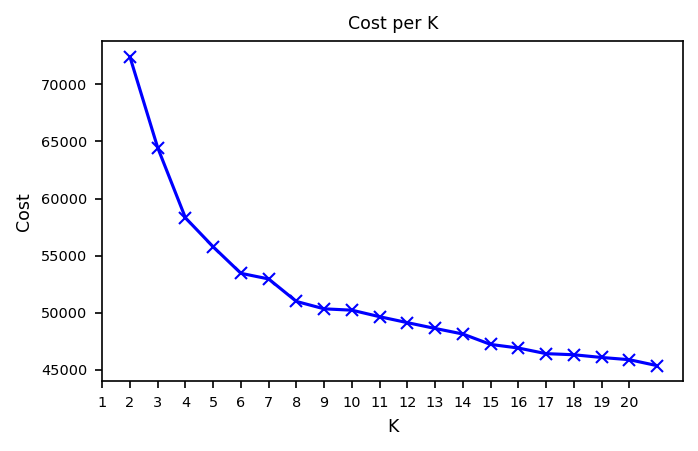

In [16]:
# plot costs with x axis integer values
import matplotlib.pyplot as plt

plt.plot(cluster_Ks, cost_per_K, 'bx-')
plt.xlabel('K')
plt.ylabel('Cost')
plt.title('Cost per K')
default_x_ticks = range(len(cluster_Ks))
plt.xticks(default_x_ticks, cluster_Ks)
plt.show()

# Content-based Recommender

In [ ]:
def get_content_recommendations(user_id, podcasts_to_rate, reviews, podcast_w_category, path=None):
    '''
    This functions gives recommendations to users based on the items they have rated previously.
    
    Inputs:
        user_id : ID of the user
        podcasts_to_rate : list of podcasts we wish to evaluate
        reviews : list of filtered reviews
        podcast_w_category: list of podcasts with categories
        
    Ouput:
        It returns a sorted list of recommendations.
    '''
    #define the podcast matrix: one-hot-encode the categories
    podcasts_matrix = pd.get_dummies(podcast_w_category.set_index('podcast_id').category)
    #combine duplicate entries
    podcasts_matrix = podcasts_matrix.reset_index().groupby('podcast_id').sum()
    
    #select the user and the corresponding ratings and average ratings per podcast
    input_user_ratings = reviews.query(f"author_id == '{user_id}'").groupby('podcast_id').mean()[['rating']]
    input_user_ratings = input_user_ratings.reset_index().groupby('podcast_id').mean()

    #calculate the weighted genre matrix for the rated podcasts
    genre_matrix = podcasts_matrix.loc[input_user_ratings.index]
    weighted_genre_matrix = genre_matrix.copy()

    #create the weighted genre matrix by iterating through every row
    for idx, row in genre_matrix.iterrows():
        row = row.values * input_user_ratings.loc[idx,'rating']
        weighted_genre_matrix.loc[idx] = row

    #calculating the user profile ratings
    user_profile = weighted_genre_matrix.div(weighted_genre_matrix.sum(axis=1), axis=0)
    user_profile_ratings = weighted_genre_matrix.sum() / weighted_genre_matrix.sum().sum()
    
    #calculate the weighted podcast matrix
    weighted_podcasts_to_rate = podcasts_to_rate.copy()
    weighted_podcasts_to_rate = np.multiply(weighted_podcasts_to_rate, user_profile_ratings.values.T)
    
    
    #sum over all rows to calculate the recommendation matrix
    rec_matrix = weighted_podcasts_to_rate.sum(axis=1)
    
    #plot the user profile ratings vs. the top recommendations
    plot_top_recommendations_vs_user(user_id, user_profile_ratings, rec_matrix, podcast_w_category, nr_cats=10, top_x=100, path=path)
    
    return rec_matrix.sort_values(ascending=False)

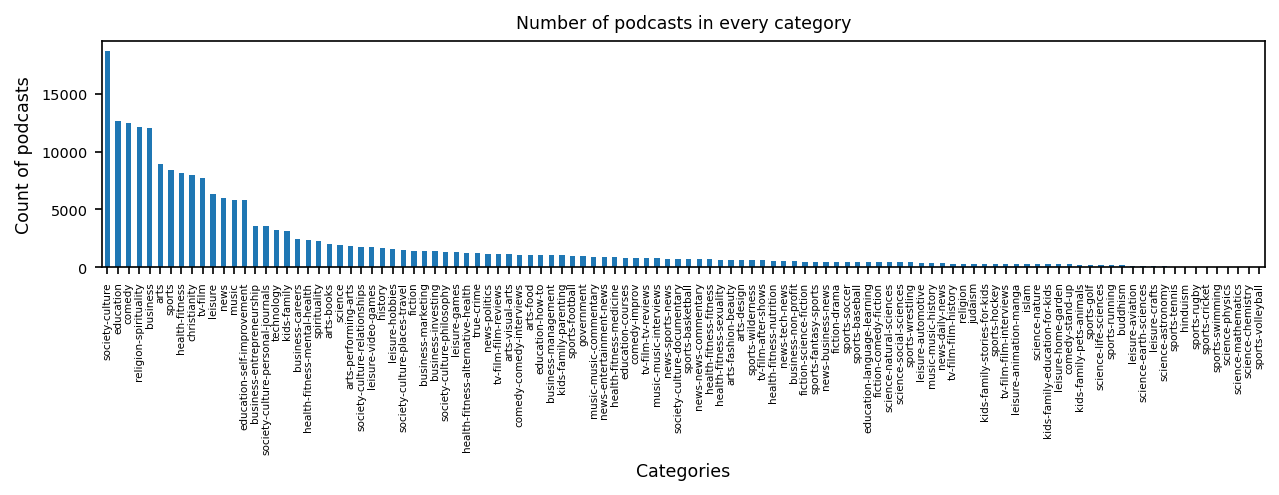

In [7]:
#define the podcast matrix: one-hot-encode the categories
podcasts_matrix = pd.get_dummies(podcast_w_category.set_index('podcast_id').category)

#combine duplicate entries
podcasts_matrix = podcasts_matrix.reset_index().groupby('podcast_id').sum()

#check the number of podcasts for every category
fig, ax = plt.subplots(figsize=(10,2), dpi=150)
podcasts_matrix.sum(axis=0).sort_values(ascending=False).plot(kind='bar', ax=ax)
ax.set_title('Number of podcasts in every category')
ax.set_ylabel('Count of podcasts')
ax.set_xlabel('Categories')
plt.xticks(fontsize=5)
plt.show()

In [8]:
#top users with the most reviews
top_users = reviews.groupby('author_id').count().sort_values('podcast_id', ascending=False).head(100)
top_users.head(10)

,podcast_id,review_title,review_content,rating,created_at
author_id,,,,,
D3307ADEFFA285C,608,608,608,608,608
96A3F0358E7808D,452,452,452,452,452
04C3B6DEFE22FB1,431,431,431,431,431
8858ED4249110B6,391,391,391,391,391
7F9EA8B1A449BFC,353,353,353,353,353
4B25015E4D7A1DA,340,340,340,340,340
A52EBC918BC19D1,307,307,307,307,307
184F09732A68A08,305,305,305,305,305
C02C514DAA9D885,302,302,302,302,302


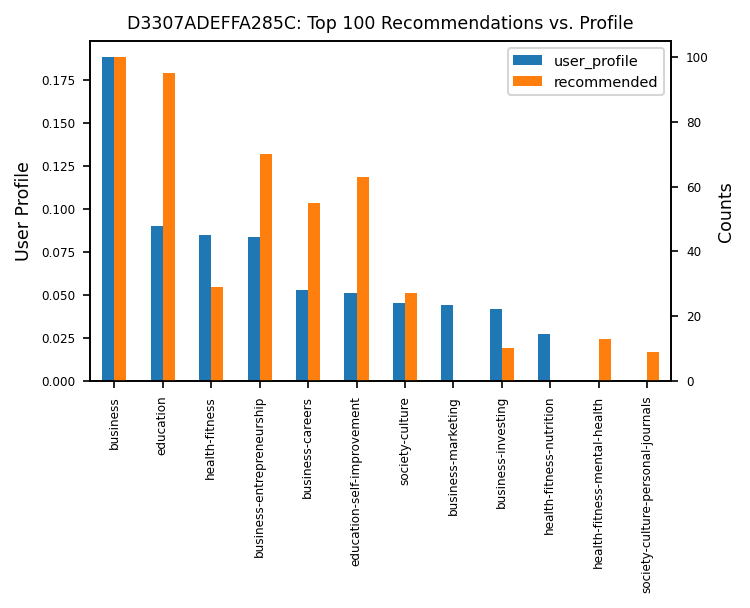

In [9]:
#Select podcasts to recommend - we can just use the whole list of podcasts
podcasts_to_rate = podcasts_matrix.copy()

for u in top_users.index[:1]:
    #get content-based recommendations
    rec_mat = get_content_recommendations(
        user_id = u,
        podcasts_to_rate=podcasts_to_rate, 
        reviews=reviews, 
        podcast_w_category=podcast_w_category,
    )

# Collaborative Filtering

In [78]:
def get_collaborative_recommendation(user_id, user_similarity, matrix_norm, similarity_th=0.3, max_users=50):
    '''
    Give collaborative filtering recommendations to a selected user, based on user similarities
    
    Inputs:
        user_id : User ID for whom we want to recommend
        user_similarity: User Similarity matrix
        similarity_th : Similarity threshold to decide similar users
        max_users : Maximum number of similar users to consider
    
    Output:
        ranked_item_score : Ranking of recommended podcasts
    '''
    picked_userid = user_id
    
    #remove the selected user from the similarity matrix 
    user_similarity_minus_user = user_similarity.drop(index=picked_userid)

    #User similarity threshold
    user_similarity_threhold = similarity_th

    #Get top n similar users
    similar_users = user_similarity_minus_user[user_similarity_minus_user[picked_userid] >= user_similarity_threhold][picked_userid].sort_values(ascending=False).head(max_users)
    
    #Podcasts that the target user listened to
    picked_userid_podcasts = matrix_norm[matrix_norm.index == picked_userid].dropna(axis=1, how='all')
    
    #podcasts that similar users listened to
    similar_user_podcasts = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')
    
    #Remove the listened-to podcasts from the podcast list
    similar_user_podcasts_minues_user = similar_user_podcasts.drop(picked_userid_podcasts.columns, axis=1, errors='ignore')
    
    item_score = {}

    #Loop through items
    for i in similar_user_podcasts_minues_user.columns:
        podcast_rating = similar_user_podcasts_minues_user[i]
        total = 0
        count = 0
        for u in similar_users.index:
            if pd.isna(podcast_rating[u]) == False:
                score = similar_users[u] * podcast_rating[u]
                total += score
                count += 1
        item_score[i] = total / count
    item_score = pd.DataFrame(item_score.items(), columns = ['podcast', 'podcast_score'])
    ranked_item_score = item_score.sort_values('podcast_score', ascending=False)
    
    #average rating of the picked user
    avg_rating = matrix[matrix.index==picked_userid].T.mean()[picked_userid]
    
    #calculate predicted user rating based on item score and average user rating
    ranked_item_score['predicted_rating'] = ranked_item_score['podcast_score'] + avg_rating
    
    return ranked_item_score

In [84]:
cluster = None

cluster_url = 'https://raw.githubusercontent.com/ferkofodor-dtu/ComputationalTools/main/author_clusters_7.csv'
clusters = pd.read_csv(cluster_url)
if cluster is not None:
    cluster_users = clusters.groupby('cluster').get_group(cluster)
    df = all_data.query(f"author_id in {list(cluster_users.reset_index()['author_id'].unique())}")
else:
    df = all_data

print(f"Cluster: {cluster}")
print(f"Number of unique users: {df['author_id'].nunique()}")
print(f"Number of unique podcasts: {df['podcast_id'].nunique()}")
print(f"Number of unique ratings: {df['rating'].nunique()}")

Cluster: None
Number of unique users: 30706
Number of unique podcasts: 35367
Number of unique ratings: 5


In [11]:
#Aggregate by podcast
agg_ratings = df.groupby('title').agg(mean_rating=('rating', 'mean'), 
                                    number_of_ratings=('rating', 'count')).reset_index()

#Podcasts with more than 5 reviews
agg_ratings_filtered = agg_ratings[agg_ratings['number_of_ratings'] >= 5]


df_filtered_podcasts = pd.merge(df, agg_ratings_filtered[['title']], on='title', how='inner')

#average out user ratings for cases when a user rates a podcast multiple times
df_filtered_podcasts = df_filtered_podcasts.groupby(['author_hash', 'podcast_hash']).mean().reset_index()

In [12]:
#Create user-item matrix
matrix = df_filtered_podcasts.pivot_table(index='author_hash', columns='podcast_hash', values='rating')

#normalize the matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
matrix_norm.head()

podcast_hash,1,2,3,4,6,7,8,9,10,11,...,35270,35275,35282,35291,35293,35320,35342,35345,35354,35363
author_hash,,,,,,,,,,,,,,,,,,,,,
1,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.117647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.076923,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
'''The most time-consuming part'''

start = time.monotonic()

#Similarity matrix using the Pearson correlation
#user_similarity = matrix_norm.T.corr()

#For convenience, this is a pre-calculated similarity matrix of all the users in the filtered database
#In order to run the code as efficiently as possible, please download the file from here:
# https://dtudk-my.sharepoint.com/:x:/g/personal/s220356_dtu_dk/EUkOJGsE6S1Pq9gkILruun8BFxtuEQw8PaW5sNFL_dzD3Q?e=LRQ2AH
user_similarity = pd.read_csv('user_similarity_full.csv', index_col=0)
user_similarity.columns = user_similarity.columns.astype(int) 

end = time.monotonic()
print(f'Generating the matrix took: {end - start:.2f}s')

user_similarity.head(10)

606.6570000000002


,1,2,3,4,5,6,7,8,9,10,...,30697,30698,30699,30700,30701,30702,30703,30704,30705,30706
author_hash,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
#Pick a user ID
picked_userid = 11

avg_rating = matrix[matrix.index==picked_userid].T.mean()[picked_userid]
print(f"The average podcast rating for {picked_userid} is {avg_rating:.2f}")

rec_list = get_collaborative_recommendation(picked_userid, user_similarity, matrix_norm, similarity_th=0.3, max_users=50)
rec_list.head()

The average podcast rating for 11 is 2.43


,podcast,podcast_score,predicted_rating
10,15605,2.666667,5.095238
2,4584,1.666667,4.095238
6,5410,0.666667,3.095238
11,25821,0.666667,3.095238
12,33139,0.666667,3.095238


# Market Basket Analysis

In [31]:
import networkx as nx
import itertools
from fa2 import ForceAtlas2

#We start by creating the baskets - which is essentially the positive reviews a user has given
baskets = [list(set(a[1]['title'].tolist())) for a in list(df.groupby('author_id'))]

In [32]:
### We can extract the unique items
items = set(list(np.concatenate(baskets).flat))
print(len(items))
print(len(baskets))

35274
30706


In [33]:
#Creating a hashed dataset for easy lookup
df_item_hash = pd.DataFrame(range(len(items)), index = list(items), columns =['hashcode'], dtype=int)
df_item_hash

,hashcode
Jay's Analysis,0
Geekin' On WDW Podcast | A Family Friendly Community of Walt Disney World Fans | Travel tips on reso...,1
Life Struggles,2
BRIDGECITYBOYS Presents: the New Music Monday Podcast,3
Pacific Beer Chat,4
...,...
Mindset Reset Radio,35269
Rusty George Podcast,35270
Change Lives Make Money: The Podcast For Online Trainers,35271
"Lobey, Lynchie and Friends with Hank Morse Podcast",35272


In [34]:
#Here we are creating an array to count how many different users have rated each podcast. We can then filter out the podcasts above a certain treshhold. We can see that treshhold support is set to 30. This is chosen by testing on different sizes.
item_count_arr = np.zeros((len(items),1))

for b in baskets:
    for item in b:
            idx = df_item_hash.loc[item,'hashcode']
            item_count_arr[idx] += 1
            
freq_items  = [df_item_hash[df_item_hash['hashcode']==x].index[0] for x in np.where(item_count_arr > 30)[0]] 

1295

In [37]:
df_freq_item_hash = pd.DataFrame(range(1,len(freq_items)+1), index=freq_items, columns=['hashcode'])
df_freq_item_hash

,hashcode
Crime and Scandal,1
Gomez Watches Seinfeld,2
You Can’t Make This Up,3
Full Release with Samantha Bee,4
Nightmare Magazine - Horror and Dark Fantasy Story Podcast (Audiobook | Short Stories),5
...,...
Lead Through Strengths,1291
Wife of Crime,1292
Snap Judgment,1293
Breaking Good - Breaking Bad Podcast,1294


In [38]:
#Now we create a matrix to store the counts of pairs
pair_mat_hashed = np.zeros((len(freq_items)+1,len(freq_items)+1))

for b in baskets:
    cand_list = [item for item in b if item in freq_items]
    if len(cand_list)<2:
        continue
    for idx, item1 in enumerate(cand_list):
        for item2 in cand_list[idx+1:]:
            i = df_freq_item_hash.loc[item1,'hashcode'] 
            j = df_freq_item_hash.loc[item2,'hashcode'] 
            pair_mat_hashed[max(i,j),min(i,j)]+=1

In [39]:
freq_pairs = [[df_freq_item_hash[df_freq_item_hash['hashcode']==x].index[0], df_freq_item_hash[df_freq_item_hash['hashcode']==y].index[0]] for x, y in zip(*np.where(pair_mat_hashed > 30))]
temp_freq_items = [item for sublist in freq_pairs for item in sublist]
freq_items_from_pairs = set(temp_freq_items)
df_freq_item_hash = pd.DataFrame(range(1,len(freq_items_from_pairs)+1), index=freq_items_from_pairs, columns=['hashcode'])
df_freq_item_hash

,hashcode
Pod Save America,1
Live and Lead for Impact with Kirsten E. Ross,2
40+ Fitness Podcast,3
PARANORMAL PODCAST,4
Best Real Estate Investing Advice Ever,5
...,...
Mystery Recipe,252
Blockchain Innovation: Interviewing The Brightest Minds In Blockchain,253
For Your Reference,254
WTF with Marc Maron Podcast,255


In [40]:
#Finally we create a 3-dimensional matrix to store the counts of triplets
triplet_mat_hashed = np.zeros((len(freq_items_from_pairs)+1,len(freq_items_from_pairs)+1,len(freq_items_from_pairs)+1))

for b in baskets:
    cand_list = [item for item in b if item in freq_items_from_pairs]
    if len(cand_list)<3:
        continue
    for idx, item1 in enumerate(cand_list):
        for item2 in cand_list[idx+1:]:
            for item3 in cand_list[idx+2:]:
                i = df_freq_item_hash.loc[item1,'hashcode'] 
                j = df_freq_item_hash.loc[item2,'hashcode'] 
                k = df_freq_item_hash.loc[item3,'hashcode']

                max = sorted([i, j, k])[2]
                min = sorted([i, j, k])[0]
                mid = sorted([i, j, k])[1]
                triplet_mat_hashed[max,min,mid]+=1

freq_triplets = [[df_freq_item_hash[df_freq_item_hash['hashcode']==x].index[0], df_freq_item_hash[df_freq_item_hash['hashcode']==y].index[0], df_freq_item_hash[df_freq_item_hash['hashcode']==z].index[0]] for x, y, z in zip(*np.where(triplet_mat_hashed > 30))]
len(freq_triplets)
temp_freq = [item for sublist in freq_triplets for item in sublist]
freq_items_from_triplets = set(temp_freq)
unique_data = [list(x) for x in set(tuple(x) for x in freq_triplets)]

In [45]:
#We will now continue to create a graph by using the networkx package. 
#We can model our list of triplets as nodes in a graph where the edges are the groups.
G = nx.Graph()
for items in unique_data:
    G.add_edge(items[0], items[1])
    G.add_edge(items[0], items[2])
    G.add_edge(items[1], items[2])

In [46]:
#This way we can use the special features of the nodes in a graph and look at common neighbors of two or more nodes to determine the list of recommendations. We will walk throgh a practical example
item_a = unique_data[4][0]
item_b = unique_data[4][1]
print(unique_data[4][2])

Better PR Now with Mark Phillips


In [47]:
#We can in fact see that the third item in the triplet is in the list. We have more items here since a lot of the same items can be connected. 
sorted(nx.common_neighbors(G, item_a, item_b))

['2000 Books for Ambitious Entrepreneurs - Author Interviews and Book Summaries',
 '40+ Fitness Podcast',
 'ADHD reWired',
 'Best Real Estate Investing Advice Ever',
 'Better PR Now with Mark Phillips',
 'Blockchain Innovation: Interviewing The Brightest Minds In Blockchain',
 'Confessions of a Terrible Husband with Nick Pavlidis',
 'Educators Lead with Jay Willis',
 'Ever Better Podcast | Inspiring Stories | Motivating | Transition with Grace | Fulfillment | Wisdom',
 'Everyday MBA',
 'Fearless And Healthy Podcast',
 'Five Minutes With Dad with Pavlos, Angela, and Nick Pavlidis',
 'Innovation and Leadership',
 'Interactive Body Balance with Mike Daciuk',
 'JumbleThink',
 'Just Forking Around',
 'Legendary Life | Transform Your Body, Upgrade Your Health & Live Your Best Life',
 'Leveling Up with Eric Siu',
 'Luke and Susie Podcast',
 'MLM Nation',
 'Maturepreneurial Podcast: Interviews with Older Entrepreneurs | Online Business Tips | Learn From Th...',
 'Mindfulness Mode',
 'Noir Fact

In [52]:
degree_distribution = sorted((d for n, d in G.degree), reverse=True)
degree_dist = dict([(degree[0], len(list(degree[1]))) for degree in itertools.groupby(degree_distribution)])

In [56]:
#We can see a list of all the podcasts and their degrees.
print(sorted(G.degree, key=lambda x: x[1], reverse=True))

[('The Learning Leader Show With Ryan Hawk', 97), ('Legendary Life | Transform Your Body, Upgrade Your Health & Live Your Best Life', 96), ('Five Minutes With Dad with Pavlos, Angela, and Nick Pavlidis', 84), ('Leveling Up with Eric Siu', 82), ('Mindfulness Mode', 82), ('Discover Your Talent–Do What You Love | Build a Career of Success, Satisfaction and Freedom', 82), ('Rental Income Podcast With Dan Lane', 80), ('ADHD reWired', 79), ('Confessions of a Terrible Husband with Nick Pavlidis', 74), ('Interactive Body Balance with Mike Daciuk', 72), ('Wisdom-Trek ©', 67), ('Everyday MBA', 65), ('The Kelly Roach Show', 65), ("Old Dawg's REI Network with Bill Manassero", 61), ('Undone Redone', 59), ('Women Taking the Lead with Jodi Flynn', 59), ('Best Real Estate Investing Advice Ever', 58), ('People Behind the Science Podcast - Stories from Scientists about Science, Life, Research, and Scien...', 55), ('The Busy Creator Podcast with Prescott Perez-Fox', 55), ('MLM Nation', 54), ('Labrador Le

In [58]:
#We can visualise the graph as following
degrees = []
for podcast in G.degree:
    degrees.append(podcast[1])

In [ ]:
forceatlas = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        edgeWeightInfluence=0.5,
                        adjustSizes=False,
                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.,
                        # Tuning
                        scalingRatio=20,
                        strongGravityMode=False,
                        gravity=200.0,
                        # Log
                        verbose=True)

positions = forceatlas.forceatlas2_networkx_layout(G, pos=None, iterations=2000)
nx.draw_networkx_nodes(G, positions, node_size=degrees, node_color='blue', label=[''])
nx.draw_networkx_edges(G, positions, edge_color='black', alpha=0.5, width=0.1, arrowstyle="-")
plt.rcParams["figure.figsize"] = [30,30]
#plt.axis('off')
plt.show()